In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

## <center>Loading Data</center>

In [2]:
df = pd.read_csv("training_jumlah_penumpang_tj.csv", delimiter=";")
df.head(6)

,bulan,tahun,jumlah_penumpang
0,1,2015,8738599
1,2,2015,7630313
2,3,2015,9383835
3,4,2015,8832441
4,5,2015,9035420
5,6,2015,8692562


In [5]:
df['month'] = df['tahun'].astype(str) + '-' + df['bulan'].astype(str)
# Convert date to datetime format
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

# Set date as the index
df = df.set_index(['month'])

df = df.drop(['bulan','tahun'], axis=1)

In [6]:
df.head(3)

,jumlah_penumpang
month,
2015-01-01,8738599
2015-02-01,7630313
2015-03-01,9383835


## <center>EDA</center>

Dari plot di bawah bisa dilihat data seasonal

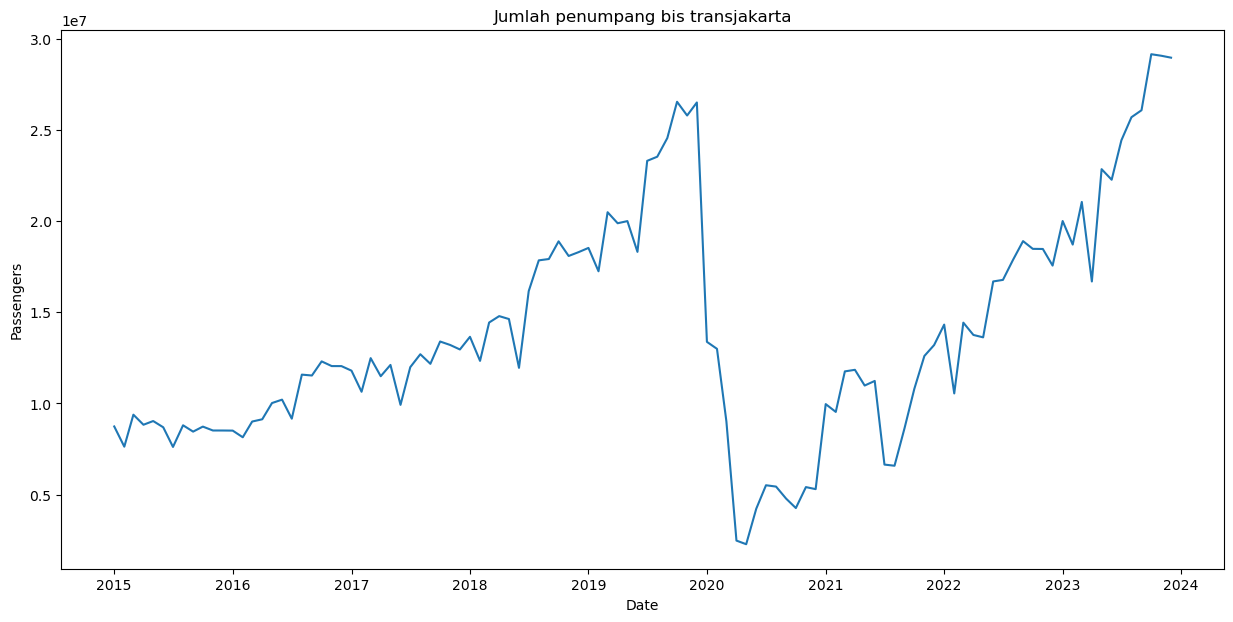

In [7]:
plt.figure(figsize=(15,7))
plt.title("Jumlah penumpang bis transjakarta")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

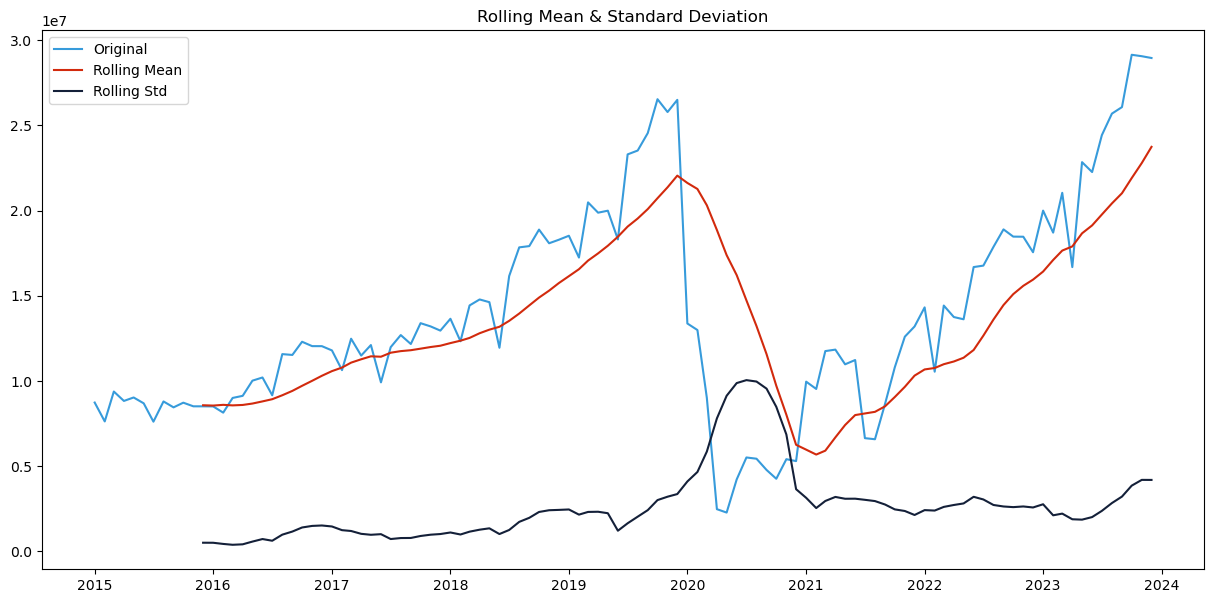

In [8]:
#Determine rolling statistics
df["rolling_avg"] = df["jumlah_penumpang"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["jumlah_penumpang"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["jumlah_penumpang"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## ADF Test

In [9]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['jumlah_penumpang'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.841910
p-value                          0.359862
#Lags Used                       3.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [10]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["jumlah_penumpang"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

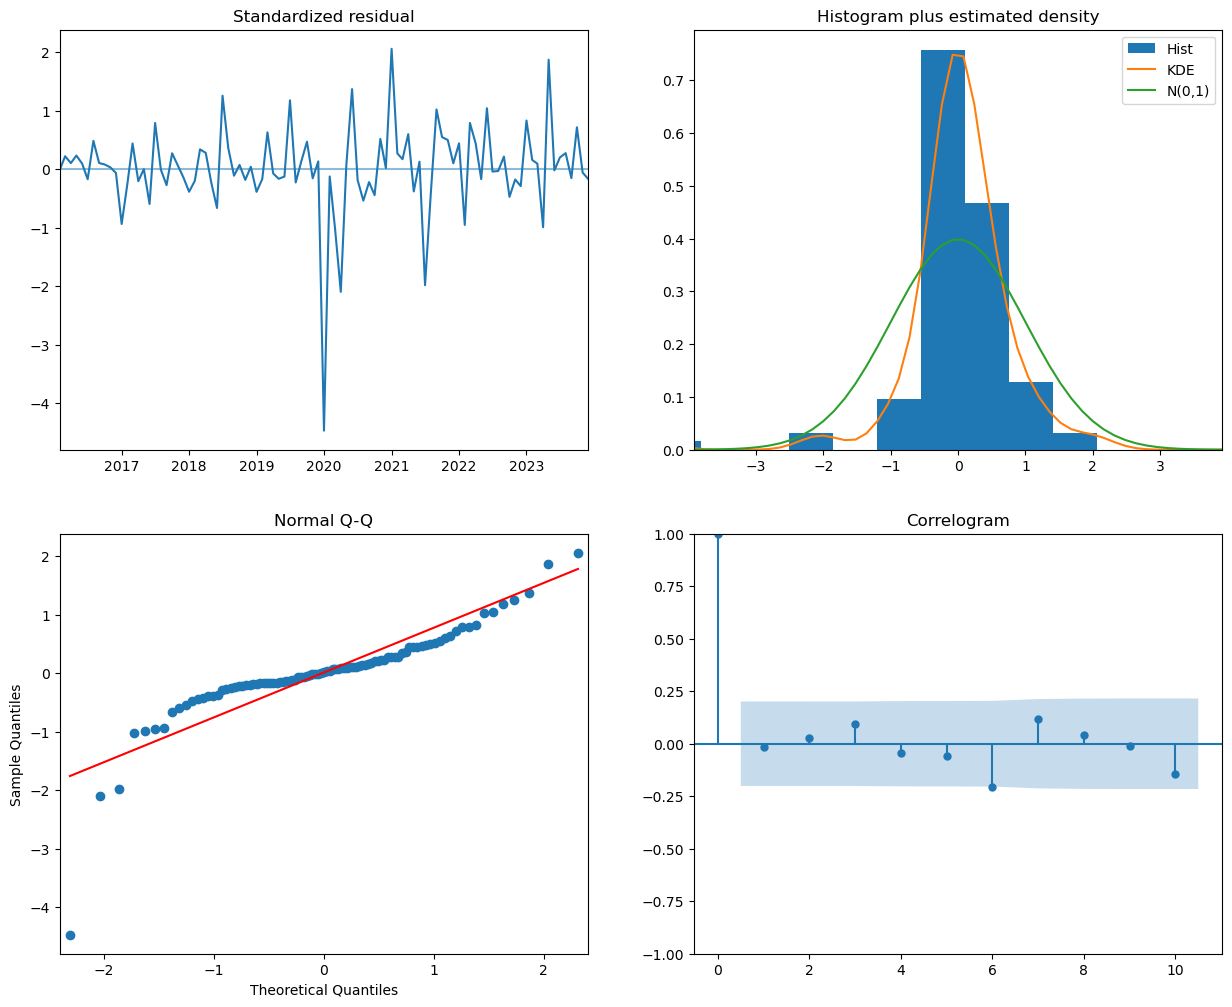

In [11]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [20]:
# Forecast function
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["jumlah_penumpang"], color='#1f76b4')
    plt.plot(fitted_series, color='red')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Jumlah Penunpang TJ")
    plt.show()

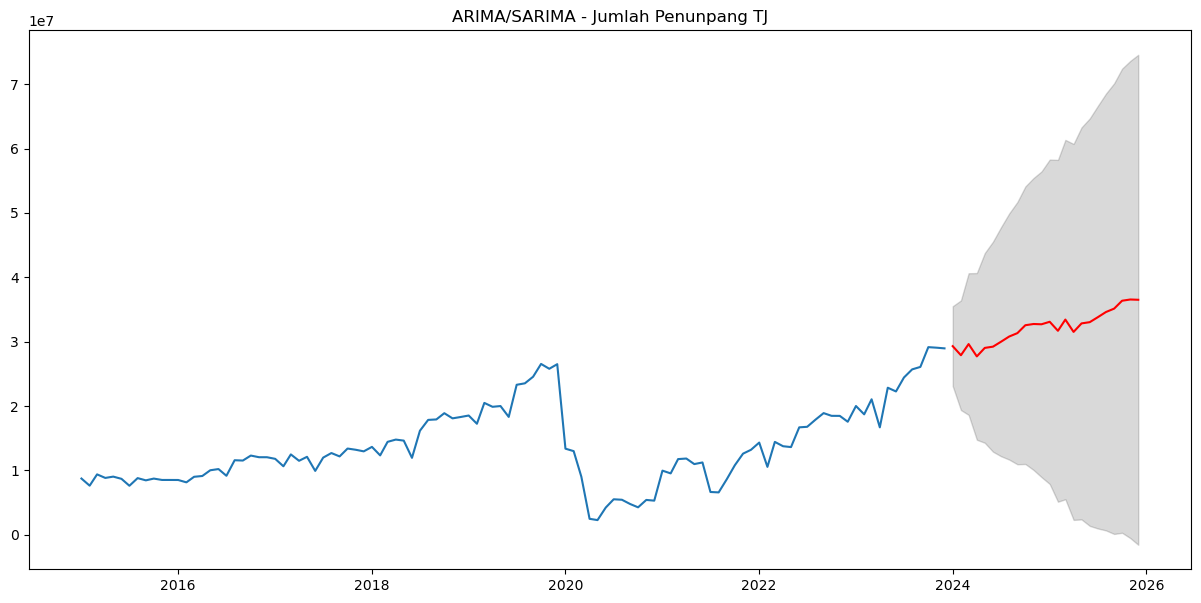

In [21]:
forecast(SARIMA_model)

## <center>SARIMAX</center>

In [22]:
# menambah variabel month 
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['jumlah_penumpang']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1539.558
Date:                              Wed, 31 Jul 2024   AIC                           3087.116
Time:                                      22:32:06   BIC                           3097.332
Sample:                                  01-01-2015   HQIC                          3091.244
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0596      0.205     -0.290      0.772      -0.462       0.343
ar.L2          0.1788      0.169      1.056      0.291      -0.153       0.510
ma.S.L12      -0.7759      0.104     -7.438      0.000      -0.980      -0.571
sigma2      9.992e+12   5.69e-15   1.76e+27      0.000    9.99e+12    9.99e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               618.26
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+42. Standard errors may be unstable.
"""

2024-01-01    2.930027e+07
2024-02-01    2.789010e+07
2024-03-01    2.962522e+07
2024-04-01    2.770887e+07
2024-05-01    2.902909e+07
2024-06-01    2.922296e+07
2024-07-01    2.998137e+07
2024-08-01    3.079496e+07
2024-09-01    3.132414e+07
2024-10-01    3.255081e+07
2024-11-01    3.274241e+07
2024-12-01    3.269910e+07
2025-01-01    3.308742e+07
2025-02-01    3.168555e+07
2025-03-01    3.342833e+07
2025-04-01    3.151301e+07
2025-05-01    3.283453e+07
2025-06-01    3.302851e+07
2025-07-01    3.378715e+07
2025-08-01    3.460074e+07
2025-09-01    3.512996e+07
2025-10-01    3.635663e+07
2025-11-01    3.654824e+07
2025-12-01    3.650493e+07
Freq: MS, dtype: float64


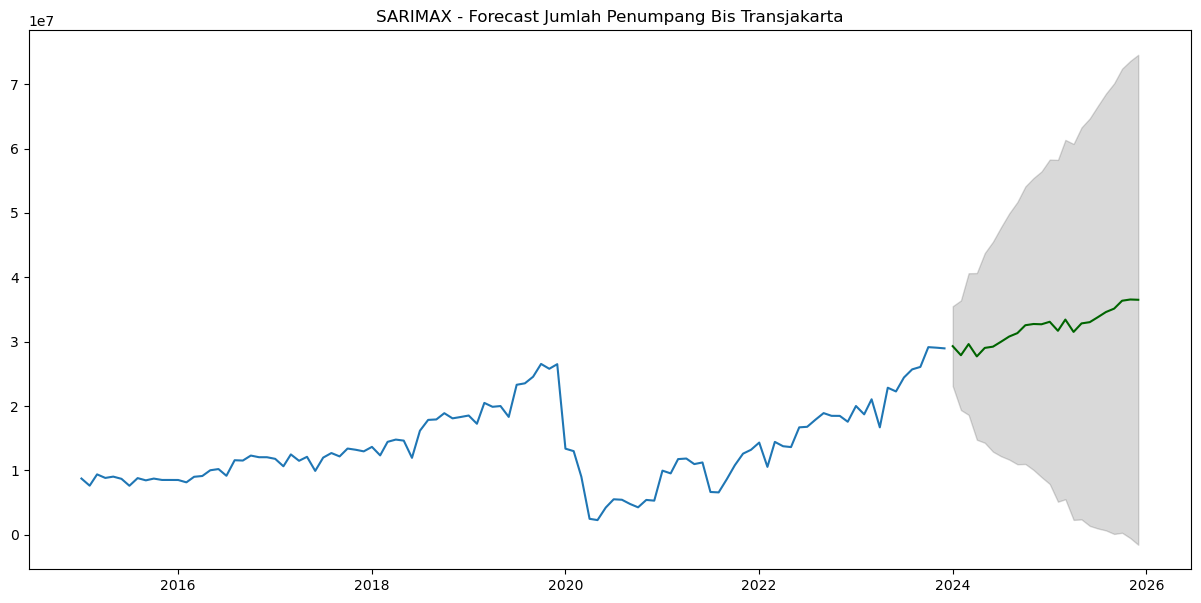

In [19]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1]+ pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    print(fitted_series)

    # accuracy 
    
    
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["jumlah_penumpang"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast Jumlah Penumpang Bis Transjakarta")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)


In [17]:
fitted_series

NameError: name 'fitted_series' is not defined